**временные ряды и модели рекуррентный нейросетей**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
#import numpy as np
#from numpy import random as rng
#import matplotlib.pyplot as plt

# import pandas as pd

# from tqdm.auto import tqdm

#tqdm.pandas()
#np.set_printoptions(precision=2)

# загружаем данные

используя рекуррентные нейросети сделаем прогноз развития уровня углекислого газа

In [2]:
import pandas as pd
import numpy as np

__co2_mm_mlo.csv__    
https://drive.google.com/file/d/1KE4cPt0l4vSm_OzuPNCf64BxMG_fygFL/view?usp=share_link

In [3]:
# читаем данные

url='https://drive.google.com/uc?id=1KE4cPt0l4vSm_OzuPNCf64BxMG_fygFL'

df = pd.read_csv(url,sep=';').convert_dtypes()
display(df.info())
display(df.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          706 non-null    Int64  
 1   month         706 non-null    Int64  
 2   decimal_date  706 non-null    Float64
 3   average       706 non-null    Float64
 4   interpolated  706 non-null    Float64
dtypes: Float64(3), Int64(2)
memory usage: 31.2 KB


None

,year,month,decimal_date,average,interpolated
95,1966,2,1966.125,321.59,321.59
363,1988,6,1988.458,353.72,353.72
247,1978,10,1978.792,332.41,332.41


In [4]:
# дубликатов нет
assert len(df) == len( df.drop_duplicates() ) 

In [5]:
# веременная метка уникальна
assert len(df) == len( df.drop_duplicates(['year','month']) ) 

In [6]:
# конвертируем временную метку
df['day'] = 1
df['ts'] = pd.to_datetime( df[['year','month','day']] )
df = df.set_index('ts')
df = df.drop(columns=['day','decimal_date'])
display(df)

,year,month,average,interpolated
ts,,,,
1958-03-01,1958,3,315.71,315.71
1958-04-01,1958,4,317.45,317.45
1958-05-01,1958,5,317.5,317.5
1958-06-01,1958,6,-99.99,317.1
1958-07-01,1958,7,315.86,315.86
...,...,...,...,...
2016-08-01,2016,8,402.25,402.25
2016-09-01,2016,9,401.03,401.03
2016-10-01,2016,10,401.57,401.57


In [7]:
display(df[['average','interpolated']].describe().T)

,count,mean,std,min,25%,50%,75%,max
average,706.0,347.831232,51.852378,-99.99,328.055,349.75,373.1625,407.7
interpolated,706.0,352.037592,26.198294,312.66,328.1375,349.75,373.1625,407.7


In [8]:
df.loc[df['average']<0.,'average'] = None # маркируем пропуски

array([<Axes: xlabel='ts'>, <Axes: xlabel='ts'>], dtype=object)

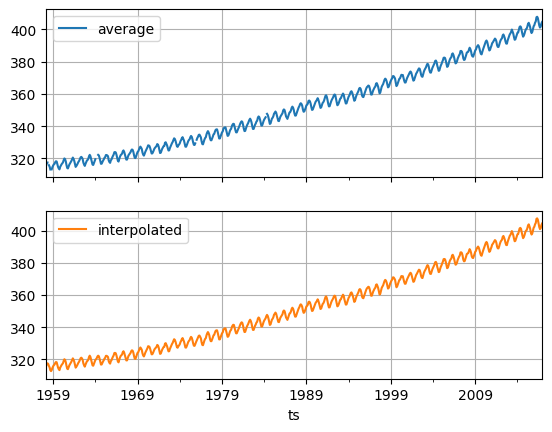

In [9]:
df[['average','interpolated']].plot(subplots=True,grid=True)

In [10]:
# average очень мало отличается от interpolated

from sklearn.metrics import mean_squared_error
display(mean_squared_error(df['average'].fillna(df['interpolated']), df['interpolated']))

0.0

In [11]:
df = df.drop(columns=['average'])
display(df)

,year,month,interpolated
ts,,,
1958-03-01,1958,3,315.71
1958-04-01,1958,4,317.45
1958-05-01,1958,5,317.5
1958-06-01,1958,6,317.1
1958-07-01,1958,7,315.86
...,...,...,...
2016-08-01,2016,8,402.25
2016-09-01,2016,9,401.03
2016-10-01,2016,10,401.57


# анализируем данные

array([[<Axes: xlabel='month'>, <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>],
       [<Axes: xlabel='month'>, <Axes: xlabel='month'>]], dtype=object)

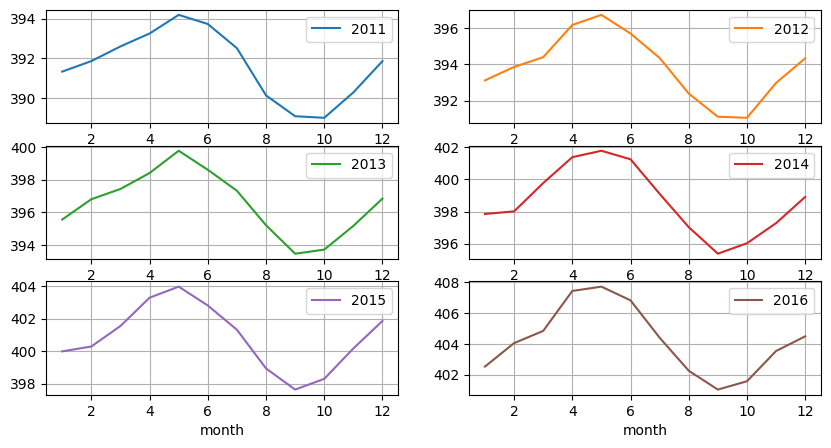

In [12]:
pd.pivot_table(
        df.query('year>2010').reset_index(),
        index='month', columns='year', values='interpolated'
    ).plot(subplots=True,figsize=(10,5),grid=True,layout=(3,2), sharex=False, )

In [13]:
from statsmodels.tsa.stattools import adfuller 

# проверка ряда на стационарность
res = adfuller( df['interpolated'].dropna()) 
print('Augmented Dickey-Fuller Statistic: {:.3f}\np-value: {:.3f}'.format(*res)) 

Augmented Dickey-Fuller Statistic: 4.818
p-value: 1.000


<Axes: xlabel='ts'>

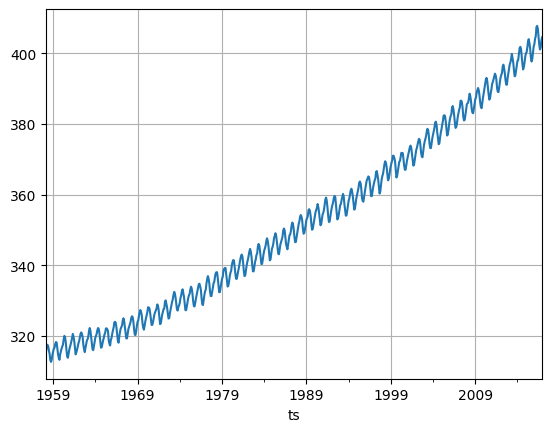

In [14]:
# имеем нестационарный временной ряд
df['interpolated'].plot(grid=True)

In [15]:
# дифференцирование ряда - переход к попарным разницам:  dy_t = ( y_t - y_t-1 )
# преобразует ряд в стационарный
df['d_interpolated'] =  df['interpolated'].diff() # ( df['interpolated'] - df['interpolated'].shift(1) )

In [16]:
# проверка ряда на стационарность после применения дифференцирования
res = adfuller( df['d_interpolated'].dropna()) 
print('Augmented Dickey-Fuller Statistic: {:.5f}\np-value: {:.5f}'.format(*res)) 

Augmented Dickey-Fuller Statistic: -5.11678
p-value: 0.00001


<Axes: xlabel='ts'>

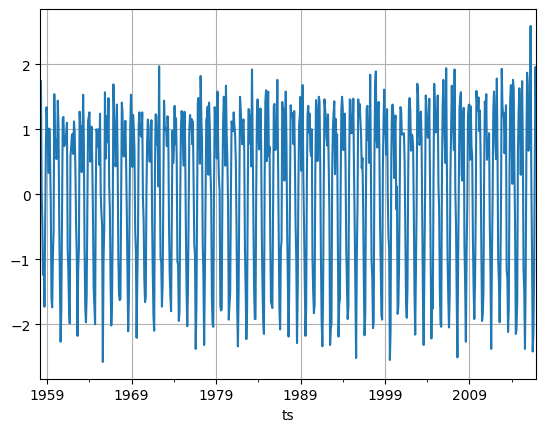

In [17]:
df['d_interpolated'].plot(grid=True)

будем предсказывать изменение значения d_interpolated

# подготовка датасета

In [19]:
df[['interpolated','d_interpolated']].describe().T

,count,mean,std,min,25%,50%,75%,max
interpolated,706.0,352.037592,26.198294,312.66,328.1375,349.75,373.1625,407.7
d_interpolated,705.0,0.125915,1.225752,-2.58,-0.97,0.55,1.14,2.59


In [20]:
df['month'].min(), df['month'].max()

(1, 12)

In [21]:
# кодируем веменную отметку (месяц)
df['month_ohe'] = list( np.eye(12,dtype=np.float32 )[ df['month'].values-1 ] )

In [22]:
df = df.sort_values(['year','month'])

d_interpolated = np.array( df[['d_interpolated']].fillna(0.) )
month_bin =  np.vstack( df['month_ohe'])
data = np.hstack([ month_bin, d_interpolated ])

n_features = data.shape[1] # размер вектора признаков для модели

display(data.shape, n_features)

del d_interpolated, month_bin

(706, 13)

13

----

In [23]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

In [24]:
# формируем датасет 
class SeqDataset(Dataset):
    
    def __init__(self, data, history_deep):
        self._history_deep = history_deep
        self._data = torch.tensor(np.array([
                 data[n:n+history_deep+1,:]
                for n in range(len(data)-history_deep)            
            ]),dtype=torch.float32)

    def __len__(self): 
        return len(self._data)

    def __getitem__(self, idx):
        return ( self._data[idx,:-1], self._data[idx,-1,[-1]] )

In [25]:
# from torch.utils.data import DataLoader

# ds_train = SeqDataset(data_train)
# x,t = ds_train[:2]

# x.shape, t.shape

In [26]:
# x,t

# строим модель

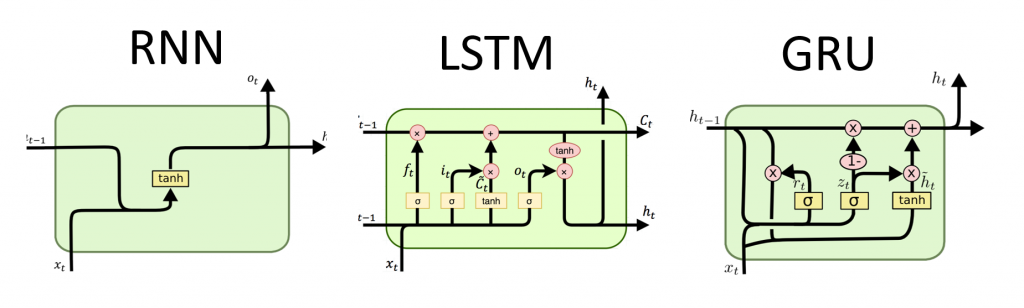

In [27]:
import torch.nn as nn

In [28]:
class Model(nn.Module):
    
    def __init__(self, n_features= n_features, hidden_dim=64):
        super().__init__()
        self._rnn = nn.LSTM( input_size=n_features, hidden_size=hidden_dim, batch_first=True) # рекуррентный слой
        self._linear = nn.Linear(hidden_dim, 1) # выходной (линейный) слой

    def forward(self,x):
        _, (hidden, _) = self._rnn(x) # обрабатываем входную последовательность
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self._linear(hidden) # считаем выход сети
        return out
    
    def predict(self,x):
        return self.forward(x)

# обучаем модель

In [29]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [30]:
model = Model().to(device)

In [31]:
criterion =  nn.MSELoss() # ф-ция потери
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) # метод оптимизации

In [32]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [33]:
# разбиваем данные на тестовые и учебные по временной отметке
year_split = 2008

f = df['year'] > year_split
data_test = data[f,:]
data_train = data[~f,:]
display( data_train.shape, data_test.shape )

history_deep = 17

ds_train = SeqDataset(data_train,history_deep=history_deep)

(610, 13)

(96, 13)

---

In [34]:
%%time

loss_history = [] # значения ф-ции потери

n_epoch = 1024*2 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    # получаем батч учебных примеров
    for x,y in DataLoader( ds_train, batch_size=len(data_train)//2, shuffle=True): 
        out = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( y.to(device),out ) # вычисляем значение ф-ции потери
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
        
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
        

  0%|          | 0/2048 [00:00<?, ?it/s]

CPU times: user 26.4 s, sys: 130 ms, total: 26.5 s
Wall time: 26.7 s


Text(0.5, 1.0, 'min loss: 0.09202')

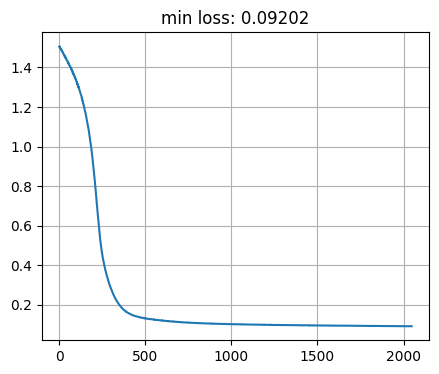

In [35]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [36]:
# считаем loss на тесте
# display( len(data_test) ) # размер датасета
ds_test = SeqDataset(data_test,history_deep=history_deep)

# вычисляем значение ф-ции потери
with torch.set_grad_enabled(False):
    for x,y in DataLoader(ds_test, batch_size=len(ds_test), shuffle=False): 
        loss_test = criterion( y.to(device), model(x.to(device)) ).item() 
        
display(loss_test)  

0.15409618616104126

## строим прогноз

In [37]:
# возьмем первую последовательность изменений длинны {seq_len} месяцев с {year_split} года
# посчитаем прогноз изменения на следующий месяц
# и на его основе авторегресиионным способом посчитаем прогноз для следующих месяцев

In [38]:
display(history_deep, year_split )

17

2008

In [39]:
# будем брать коды месяцев из тестового датасета
# подставлять туда полученные от модели значения прогноза изменений
predicted = data.copy()

with torch.set_grad_enabled(False): 
    for idx in range(len(data)-history_deep): # будем двигать окно размера seq_len по месяцам
        x = predicted[idx:idx+history_deep]  # входная последовательность 
        predicted[idx+history_deep,-1] = model( # считаем прогноз и пишем его в таблицу результата
                torch.FloatTensor(x[np.newaxis,:]).to(device)
            ).cpu().numpy().flatten()[0]

In [40]:
df['d_predicted'] = predicted[:,-1]

In [41]:
# обратное преобразование:  y_t = dy_t + y_t-1
s = list(df.iloc[:history_deep]['interpolated']) 
for d in df.iloc[history_deep:]['d_predicted']: s.append(s[-1]+d)

In [42]:
df['predicted'] = s

In [43]:
t = df.query(f'year=={year_split}').index[0]
v0,v1 = df[['interpolated','predicted']].min().min(), df[['interpolated','predicted']].max().max()

<Axes: xlabel='ts'>

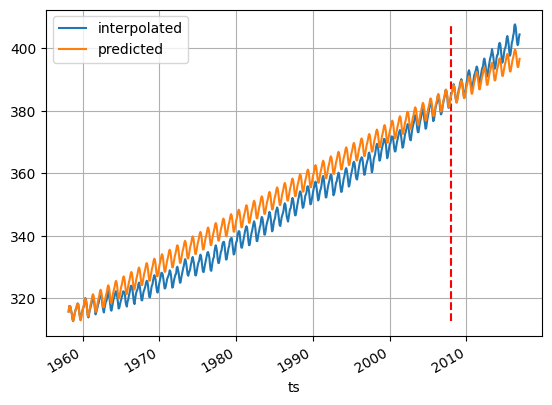

In [44]:
fig,ax = plt.subplots()
ax.plot([t,t],[v0,v1],linestyle='dashed',color='r')
df[['interpolated','predicted']].plot(ax=ax,grid=True)

## модель ARIMA

In [73]:
train = df.query(f'year<{year_split}')[['interpolated']]

In [74]:
# импортируем функцию для автоматического подбора параметров модели ARIMA
from pmdarima import auto_arima

# настроим поиск параметров на обучающей выборке
model_ = auto_arima(
        train, 
        start_p=1, 
        start_q=1,
        max_p=3, 
        max_q=3, 
        m=12, 
        start_P=0,
        seasonal=True,
        d=None, 
        D=1, 
        trace=True, 
        error_action ='ignore', 
        suppress_warnings = True,  
        stepwise = True
    )           

# выведем результат
print(model_.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=266.029, Time=0.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=633.737, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=438.877, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=265.471, Time=0.51 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=568.220, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=267.468, Time=0.74 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=267.468, Time=1.29 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=422.008, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=4.96 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=266.272, Time=0.89 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=277.919, Time=0.54 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=267.708, Time=1.58 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=263.828, Time=1.16 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AI

In [98]:
# тестовый прогнозный период начнется с конца обучающего периода
# и закончится в конце тестового

n_periods = 12*7 # прогноз в месяцах
predicted = model_.predict( start=len(train), n_periods=n_periods)

# predicted

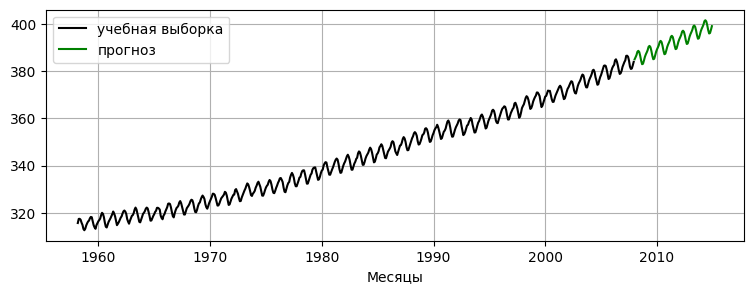

In [99]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train, color = 'black',label='учебная выборка')
#ax.plot(test, color = 'red',label='тестовая выборка')
ax.plot(predicted, color = 'green',  label='прогноз')

ax.set_xlabel('Месяцы', )
#ax.set_ylabel('значение',)
ax.legend(title = '', loc = 'upper left', )
ax.grid()